# Spoiler Detection

In [28]:
import numpy as np
import json
import pickle
import time
import os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split 
from pprint import pprint

### load data

https://www.kaggle.com/rmisra/imdb-spoiler-dataset#IMDB_reviews.json (573.913 Reviews)

In [29]:
with open('../../Daten/IMDB_reviews/IMDB_reviews2.json') as f:
    data = json.load(f)
# pprint(data)

In [30]:
X_data, y_data = list(), list()
count_spoiler, count_non_spoiler = 0, 0
num_data_per_class = 10000

for i in range(len(data["data"])):
    if data["data"][i]["is_spoiler"] == True and count_spoiler < num_data_per_class:
        X_data.append(data["data"][i]["review_text"])
        y_data.append(1)
        count_spoiler+=1
    if data["data"][i]["is_spoiler"] == False and count_non_spoiler < num_data_per_class:
        X_data.append(data["data"][i]["review_text"])
        y_data.append(0)
        count_non_spoiler+=1
    
X_data = np.asarray(X_data)
y_data = np.asarray(y_data)

# y_data = [1 if y == True else 0 for y in y_data] # convert label to 0 or 1

In [31]:
print("Anz. Spoiler: {}".format(sum([y for y in y_data])))
print("Anz. Nicht-Spoiler: {}".format(sum([1 if y == 0 else 0 for y in y_data])))

Anz. Spoiler: 10000
Anz. Nicht-Spoiler: 10000


#### save an load pickle files

In [32]:
pickle.dump(y_data, open("pickle_files/y_data.pickle", "wb"))
pickle.dump(X_data, open("pickle_files/X_data.pickle", "wb"))

In [33]:
X_data = pickle.load(open("pickle_files/X_data.pickle", "rb"))
y_data = pickle.load(open("pickle_files/y_data.pickle", "rb"))

#### train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size = 0.2, shuffle=True, stratify = y_data)
X_train.shape
X_test.shape

(4000,)

#### text to int

In [35]:
t = Tokenizer()
t.fit_on_texts(X_data)

In [36]:
# print(t.word_counts)
# print(t.document_count)
# print(t.word_docs)

In [37]:
max_length = max([len(s.split()) for s in X_data])
vocab_size = len(t.word_index) + 1
print("max_length: {}".format(max_length))
print("vocab_size: {}".format(vocab_size))
max_length = 200

max_length: 2140
vocab_size: 59933


In [38]:
# Tokens to index in vocab
X_train_tokens = t.texts_to_sequences(X_train)
X_test_tokens = t.texts_to_sequences(X_test)

In [39]:
X_train_pad = sequence.pad_sequences(X_train_tokens, maxlen=max_length)
X_test_pad = sequence.pad_sequences(X_test_tokens, maxlen=max_length)

#### save an load pickle files

In [40]:
pickle.dump(X_train_pad, open("pickle_files/X_train_pad.pickle", "wb"))
pickle.dump(X_test_pad, open("pickle_files/X_test_pad.pickle", "wb"))
pickle.dump(y_train, open("pickle_files/y_train.pickle", "wb"))
pickle.dump(y_test, open("pickle_files/y_test.pickle", "wb"))

In [41]:
X_train_pad = pickle.load(open("pickle_files/X_train_pad.pickle", "rb"))
X_test_pad = pickle.load(open("pickle_files/X_test_pad.pickle", "rb"))
y_train = pickle.load(open("pickle_files/y_train.pickle", "rb"))
y_test = pickle.load(open("pickle_files/y_test.pickle", "rb"))

In [42]:
print(X_train_pad.shape)
print(X_test_pad.shape)
print(y_train.shape)
print(y_test.shape)

(16000, 200)
(4000, 200)
(16000,)
(4000,)


#### build the model

In [43]:
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 64)           3835712   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,860,609
Trainable params: 3,860,609
Non-trainable params: 0
_________________________________________________________________


#### train the model

In [45]:
start_time = time.clock()

batch_size = 128
epochs = 10
history = model.fit(X_train_pad, y_train, 
          validation_data=(X_test_pad, y_test),
          batch_size=batch_size, epochs=epochs, verbose=1)

elapsed_time = time.clock() - start_time
print('Cycle Time: {0:.2f}s'.format(round(elapsed_time)))

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 99s 6ms/step - loss: 0.6274 - acc: 0.6546 - val_loss: 0.5171 - val_acc: 0.7418
Epoch 2/10
16000/16000 [==============================] - 100s 6ms/step - loss: 0.4382 - acc: 0.8017 - val_loss: 0.4580 - val_acc: 0.7923
Epoch 3/10
16000/16000 [==============================] - 102s 6ms/step - loss: 0.3426 - acc: 0.8576 - val_loss: 0.5404 - val_acc: 0.7883
Epoch 4/10
16000/16000 [==============================] - 98s 6ms/step - loss: 0.2758 - acc: 0.8930 - val_loss: 0.5237 - val_acc: 0.7850
Epoch 5/10
16000/16000 [==============================] - 93s 6ms/step - loss: 0.2126 - acc: 0.9239 - val_loss: 0.5913 - val_acc: 0.7615
Epoch 6/10
16000/16000 [==============================] - 91s 6ms/step - loss: 0.1713 - acc: 0.9414 - val_loss: 0.6367 - val_acc: 0.7688
Epoch 7/10
16000/16000 [==============================] - 95s 6ms/step - loss: 0.1333 - acc: 0.9549 - val_loss: 0.7544 - val_ac

Cycle Time: 958.00s - 10 Epochs - 16 

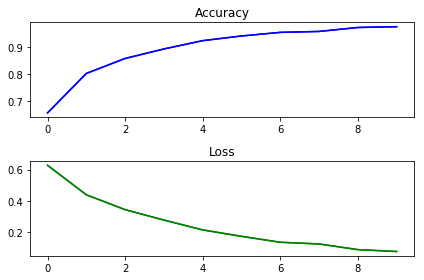

In [46]:
import matplotlib.pyplot as plt
diag, axes = plt.subplots(nrows = 2, ncols = 1)
for ax in axes:
    axes[0].plot(history.history['acc'], c="b")
    axes[0].set_title('Accuracy')
    axes[1].plot(history.history['loss'], c="g")
    axes[1].set_title('Loss')
plt.tight_layout()

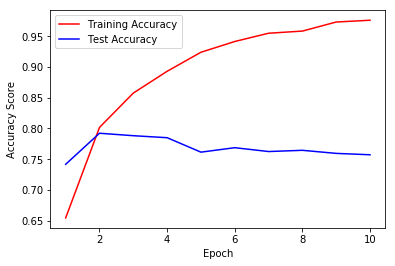

In [47]:
training_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r-')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show();

In [48]:
print('loss and accuracy of the model with test data')
model.evaluate(X_test_pad, y_test, batch_size=1, verbose=1) #[1.6744082060362069, 0.71525] | [0.9358986402363283, 0.75725]
# y_pred = model.predict(X_test_pad)

loss and accuracy of the model with test data
4000/4000 [==============================] - 97s 24ms/step


[0.9358986402363283, 0.75725]

#### save model

In [49]:
path = "./Models/"
model_file_name = "Spoiler_Detection_Model"
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
count = 0
for f in files:
    if (f.find(model_file_name) != -1):
        count +=1
filename = '' + path + model_file_name + str(count+1) + '.h5'
model.save(filename)

#### load model

In [50]:
from keras.models import load_model
model = load_model('Models/Spoiler_Detection_Model1.h5')

#### prediction

In [51]:
test_sample = ["The main character dies in the movie and also his sister.", "spoiler alarm", "I love the movie and would recommend it"]
test_sample_tokens = t.texts_to_sequences(test_sample)
print(test_sample_tokens)
test_sample_tokens_pad = sequence.pad_sequences(test_sample_tokens, maxlen=max_length)
model.predict(x=test_sample_tokens_pad)

[[1, 295, 82, 1270, 7, 1, 12, 2, 80, 17, 1462], [893, 13653], [9, 130, 1, 12, 2, 69, 442, 8]]


array([[0.43797684],
       [0.97607374],
       [0.23623365]], dtype=float32)

### TODOs
* pretrained word embeddings (word2vec, glove, fasttext)
* preprocessing steps (lemmatisation, remove stopwords..)
* more complex network architecture
* train on the whole dataset
* split data into train, test, validation
* use Google BERT